In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from matplotlib.font_manager import FontProperties
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
import itertools

In [2]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [3]:
# linux path
# path1 = './'
# path2 = '/'

# windows path
path1 = '.\\'
path2 = '\\'

In [4]:
seasonsTS = ("s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1","s1")
trendsTS = ("t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1","t1")
noisesTS = ("n1","n2","n3","n4","n5","n6","n7","n11","n12","n21","n22","n31","n32","n41","n42","n51","n52","n61","n62","n71","n72")

cases = ("t1_n1_s1", "t1_n2_s1", "t1_n3_s1", "t1_n4_s1", "t1_n5_s1", "t1_n6_s1", "t1_n7_s1", \
         "t1_n11_s1", "t1_n12_s1", "t1_n21_s1", "t1_n22_s1", "t1_n31_s1", "t1_n32_s1", "t1_n41_s1", "t1_n42_s1", "t1_n51_s1", "t1_n52_s1", \
            "t1_n61_s1", "t1_n62_s1", "t1_n71_s1", "t1_n72_s1")

In [5]:
# Trend = list()
# for trend_i in trendsTS:
#     t = pd.read_csv(f"{path1}Components{path2}{trend_i}.csv", decimal=',')
#     trend = pd.DataFrame(t, dtype=float)
#     Trend.append(trend['Value'])
# Component_of_TS = Trend[::]
# Component_name = "Trend"
# range_of_imfs = range(5)

# Noise = list()
# for noise_i in noisesTS:
#     n = pd.read_csv(f"{path1}Components{path2}{noise_i}.csv", decimal=',')
#     noise = pd.DataFrame(n, dtype=float)
#     Noise.append(noise['Value'])
# Component_name = "Noise"
# range_of_imfs = range(9, 1, -1)
# Component_of_TS = Noise[::]

# Season = list()
# for season_i in seasonsTS:
#     s = pd.read_csv(f"{path1}Components{path2}{season_i}.csv", decimal=',')
#     season = pd.DataFrame(s, dtype=float)
#     Season.append(season['Value'])
# Component_of_TS = Season[::]
# Component_name = "Season"
# range_of_imfs = range(1,8)



In [6]:
index = list()
TS = list()

data = pd.read_csv(f"{path1}Cases{path2}{cases[0]}.csv", decimal=',')
df = pd.DataFrame(data, dtype=float)
index = df.index

for case_i in cases:
    data = pd.read_csv(f"{path1}Cases{path2}{case_i}.csv", decimal=',')
    df = pd.DataFrame(data, dtype=float)
    TS.append(df.values)

# тестовый анализ

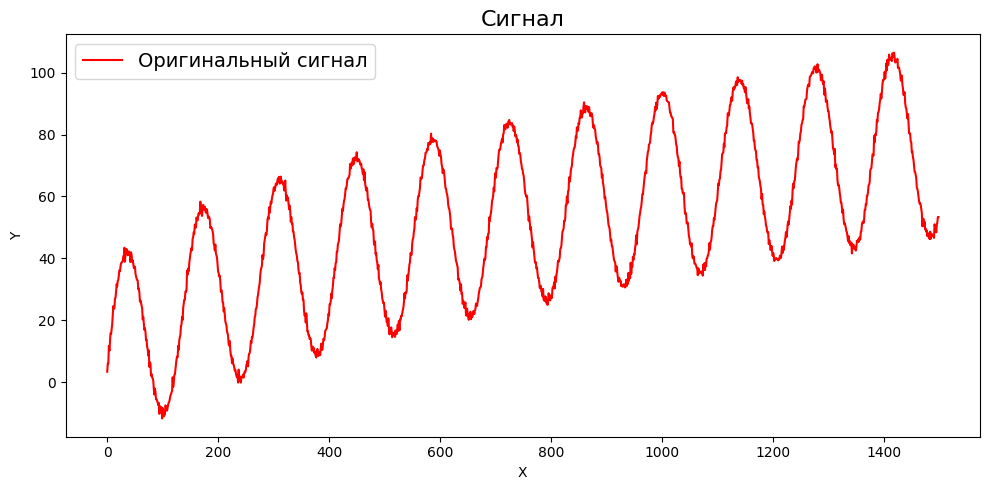

In [7]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


axs.plot(index, TS[2].T[0], color="#ff0000")
plt.title('Сигнал', fontsize=16)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Оригинальный сигнал', '1 IMFs'], prop=FontProperties(size=14))

plt.tight_layout()

In [130]:
alpha = 30000
omega_init = 1001
tau = 2

fs = 20000
tol = 1e-6

In [131]:
imf, _, _ = VME(TS[2].T[0], Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)

In [132]:
residual1 = TS[2].T[0] - imf.real

In [133]:
alpha = 30000
omega_init = 1001
tau = 2

fs = 20000
tol = 1e-6

In [134]:
imf, _, _ = VME(residual1, Alpha=alpha, omega_int=omega_init, fs=fs, tau=tau, tol=tol)

In [135]:
residual2 = residual1 - imf.real

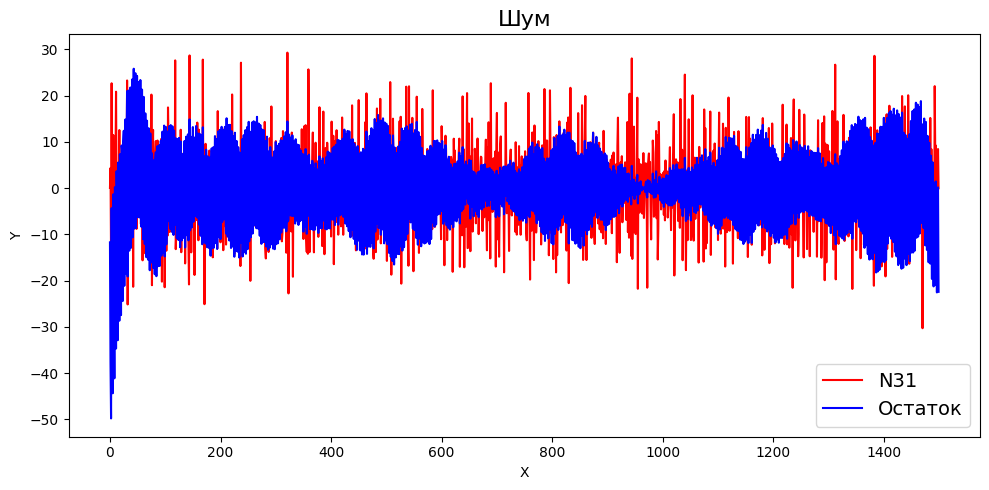

In [136]:
n = pd.read_csv(f"{path1}Components{path2}n31.csv", decimal=',')
noise = pd.DataFrame(n, dtype=float)
Component_of_TS = noise['Value']

fig, axs = plt.subplots(figsize=(10,5), nrows=1)


axs.plot(index, Component_of_TS, color="#ff0000")
axs.plot(index, residual2, color="#0000ff")
plt.title('Шум', fontsize=16)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['N31', 'Остаток'], prop=FontProperties(size=14))

plt.tight_layout()

In [49]:
r2_score(residual2, Component_of_TS)

0.7889939481482366

# Тренд

In [58]:
# набор параметров
alpha = (0, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 2501, 5001, 7501, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001, 50001)
tau = (0, 1, 2, 3, 4, 5) # noise-tolerance (no strict fidelity enforcement)
fs = 20000
tol = 1e-6

featurecount = 5


In [59]:
best_params = np.zeros((len(TS), 10), dtype=dict)
best_metriks = np.zeros((len(TS), 4), dtype=dict)

f = np.zeros((len(TS), 1500), dtype=list)
k_i = np.zeros(len(TS), dtype=int)


In [60]:
#  R2
MetricName = "R2"
calculate_metric = lambda y, y_pred: r2_score(y, y_pred)

default_value = -np.inf
maxmin = lambda criteria: np.max(criteria)
arg_maxmin = lambda criteria: np.argmax(criteria)
find_new_best_params = lambda max_criteria, best_metriks: max_criteria > best_metriks


# #  R2Adj
# MetricName = "R2Adj"
# calculate_metric = lambda y, y_pred, featurecount: r2_score_adjusted(y, y_pred, featurecount)


# #  AIC
# MetricName = "AIC"
# calculate_metric = lambda y, y_pred, k: calculate_aic(y, y_pred, k)

# default_value = np.inf
# maxmin = lambda criteria: np.min(criteria)
# arg_maxmin = lambda criteria: np.argmin(criteria)
# find_new_best_params = lambda max_criteria, best_metriks: max_criteria < best_metriks


# # BIC
# MetricName = "BIC"
# calculate_metric = lambda y, y_pred, k: calculate_bic(y, y_pred, k)

In [61]:
for i in range(len(TS)):
    best_metriks[i][0] = {"Time Series": f"TS{i+1}", "Component": "Trend", f"{MetricName}": default_value}
    best_metriks[i][1] = {"Time Series": f"TS{i+1}", "Component": "Season", f"{MetricName}": default_value}
    best_metriks[i][2] = {"Time Series": f"TS{i+1}", "Component": "Noise", f"{MetricName}": default_value}
    best_metriks[i][3] = {"Time Series": f"TS{i+1}", "Component": "Noise-freg", f"{MetricName}": default_value}
    
    for j in range(10):
        best_params[i][j] = {"Time Series": f"TS{i+1}", "Metric": f"{MetricName}", "Trend/Season/Noise": None, "IMFs" : f"1 - {j+1}",  "alpha": 0, "tau": 0, "W init": 1}

In [62]:
# для всех лчм
for ts_i in range(len(TS)):
    f[ts_i] = TS[ts_i].reshape((1500,))
    k_i[ts_i] = 0

    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while( (k_i[ts_i] < 10) and isbest_params ):
        isbest_params = False

        # для всех значений alpha
        criteria = np.zeros(len(alpha), dtype=float)
        j = 0          # j - индекс значения параметра
        for alpha_i in alpha:
            u, _, _ = VME(f[ts_i], alpha_i, omega_int=1, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["alpha"] = alpha[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real
            isbest_params = True
        

        # для всех значений omega init
        criteria = np.zeros(len(omega_init), dtype=float)
        j = 0
        for omega_init_i in omega_init:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_init_i, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["W init"] = omega_init[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real


        # для всех значений tau
        criteria = np.zeros(len(tau), dtype=float)
        j = 0
        for tau_i in tau:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=tau_i, tol=1e-6)

            criteria[j] = calculate_metric(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][0][f"{MetricName}"]) ):
            best_metriks[ts_i][0][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 --- {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Trend"
            best_params[ts_i][k_i[ts_i]]["tau"] = tau[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                          fs=20000, tau=best_params[ts_i][k_i[ts_i]]["tau"], tol=1e-6)
            
            best_imfs = u.T.real
            isbest_params = True
        


        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [63]:
for ts_i in range(len(TS)):
    best_metriks[ts_i][0][f"{MetricName}"] = format(best_metriks[ts_i][0][f"{MetricName}"], ".5f")

# Сезон

In [64]:
season_k = np.zeros(len(TS), dtype=int)
# для всех лчм
for ts_i in range(len(TS)):
    season_k[ts_i] = k_i[ts_i]
    
    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while( (k_i[ts_i] < 10) and isbest_params ):
        isbest_params = False

        # для всех значений alpha
        criteria = np.zeros(len(alpha), dtype=float)
        j = 0          # j - индекс значения параметра
        for alpha_i in alpha:
            u, _, _ = VME(f[ts_i], alpha_i, omega_int=1, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["alpha"] = alpha[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real
            isbest_params = True
        

        # для всех значений omega init
        criteria = np.zeros(len(omega_init), dtype=float)
        j = 0
        for omega_init_i in omega_init:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], omega_init_i, fs=20000, tau=1, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["W init"] = omega_init[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=1, tol=1e-6)
            best_imfs = u.T.real


        # для всех значений tau
        criteria = np.zeros(len(tau), dtype=float)
        j = 0
        for tau_i in tau:
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], fs=20000, tau=tau_i, tol=1e-6)

            criteria[j] = calculate_metric(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = maxmin(criteria)
        argmax_criteria = arg_maxmin(criteria)

        if ( find_new_best_params(max_criteria, best_metriks[ts_i][1][f"{MetricName}"]) ):
            best_metriks[ts_i][1][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} --- {k_i[ts_i]}'
            best_params[ts_i][k_i[ts_i]]["Trend/Season/Noise"] = "Season"
            best_params[ts_i][k_i[ts_i]]["tau"] = tau[argmax_criteria]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                          fs=20000, tau=best_params[ts_i][k_i[ts_i]]["tau"], tol=1e-6)
            
            best_imfs = u.T.real
            isbest_params = True
        


        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [65]:
for ts_i in range(len(TS)):
    best_metriks[ts_i][1][f"{MetricName}"] = format(best_metriks[ts_i][1][f"{MetricName}"], ".5f")

In [66]:
one_dimensional_best_params = list(itertools.chain(*best_params))

best_params_output = [v for v in one_dimensional_best_params if not (v['Trend/Season/Noise'] is None)]
best_params_output

[{'Time Series': 'TS1',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0,
  'W init': 5001},
 {'Time Series': 'TS1',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 50000,
  'tau': 0,
  'W init': 7501},
 {'Time Series': 'TS2',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0,
  'W init': 10001},
 {'Time Series': 'TS2',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 50000,
  'tau': 0,
  'W init': 20001},
 {'Time Series': 'TS3',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0,
  'W init': 5001},
 {'Time Series': 'TS3',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Season',
  'IMFs': '2 --- 2',
  'alpha': 50000,
  'tau': 0,
  'W init': 20001},
 {'Time Series': 'TS4',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 50000,
  'tau': 0

In [67]:
np.shape(one_dimensional_best_params)

(210,)

In [68]:
np.shape(best_params_output)

(42,)

In [69]:
filename=f"./Output-VME/Parameters-{MetricName}-VME.csv"

fields = best_params[0][0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows(best_params_output)  # Write data rows

# Шум

In [70]:
for ts_i in range(len(TS)):
    criteria = calculate_metric(Noise[ts_i], f[ts_i])
    if (find_new_best_params(criteria, best_metriks[ts_i][2][f"{MetricName}"])):
        best_metriks[ts_i][2][f"{MetricName}"] = criteria

# ШУМ freguency

In [71]:
for ts_i in range(len(TS)):
    original_noise = np.abs(np.fft.rfft(Noise[ts_i]))
    imf_freg = np.abs(np.fft.rfft(f[ts_i].astype(float)))

    criteria = calculate_metric(original_noise, imf_freg)
    if (find_new_best_params(criteria, best_metriks[ts_i][3][f"{MetricName}"])):
        best_metriks[ts_i][3][f"{MetricName}"] = criteria

# Вывод

In [72]:
filename=f"./Output-VME/Best_Metriks-{MetricName}-VME.csv"

fields = best_metriks[0][3].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i][0]])  # Write data rows
        writer.writerows([best_metriks[ts_i][1]])  # Write data rows
        writer.writerows([best_metriks[ts_i][2]])  # Write data rows
        writer.writerows([best_metriks[ts_i][3]])  # Write data rows